In [31]:
import tensorflow as tf
from tensorflow.contrib.layers import xavier_initializer
import tensorflow.contrib.slim as slim
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import os
from tqdm import tqdm_notebook 
from sklearn.utils import shuffle 

  classname                         img
0       c34  marge_simpson/pic_0601.jpg
1       c34  marge_simpson/pic_0180.jpg
2       c34  marge_simpson/pic_0196.jpg
3       c34  marge_simpson/pic_0698.jpg
4       c34  marge_simpson/pic_0083.jpg
   c0  c17  c30  c32  c34  c8
0   0    0    0    0    1   0
1   0    0    0    0    1   0
2   0    0    0    0    1   0
3   0    0    0    0    1   0
4   0    0    0    0    1   0
(480, 640, 3)
(50, 50, 3)


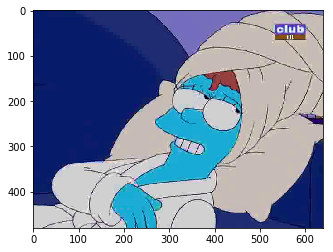

In [32]:
os.chdir('//data/examples/')
simpson_x = pd.read_csv('simpson_preproc/simpson_img_list.csv')
print(simpson_x.head())

img = cv2.imread('simpson_preproc/' + simpson_x.img.iloc[0])
plt.imshow(img)

simpson_x = simpson_x[simpson_x.img.str.contains('simpson')]
simpson_y = pd.get_dummies(simpson_x['classname'])
print(simpson_y.head())
print(img.shape)

img = cv2.resize(img, (50,50))
print(img.shape)

In [33]:
x_train, x_test, y_train, y_test = train_test_split(simpson_x, simpson_y, test_size=0.15, random_state=42)  
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(6182, 2) (1092, 2) (6182, 6) (1092, 6)


In [34]:
def get_batch_sample(x,y,batch):    
    x = shuffle(x)
    sample_index = x[:batch].index            
    x_sample = x.loc[sample_index]
    y_sample = y.loc[sample_index]
   
    x_batch = None    
    y_batch = y_sample.values  
    for i in x_sample["img"]:        
        dir_img = 'simpson_preproc/' + i
        img = cv2.imread(dir_img)
        img = img / 255
        img = cv2.resize(img, (224,224))
        img = img.reshape((1,224,224,3))
        if x_batch is None:
            x_batch = img
        else:
            x_batch = np.concatenate((x_batch, img))
        
    return x,y,x_batch,y_batch  

In [36]:
x_train, y_train, x_batch,y_batch = get_batch_sample(x_train, y_train, 10)
print(x_batch.shape)
print(y_batch.shape)

(10, 224, 224, 3)
(10, 6)


In [37]:
def fill_channel(input_tensor, output_channel):
    input_channel = input_tensor.get_shape().as_list()[-1]
    if input_channel != output_channel:
        pooled_input = tf.pad(input_tensor, [[0, 0], [0, 0], [0, 0], [abs(output_channel - input_channel)//2, abs(output_channel - input_channel)//2]])
    else:
        pooled_input = input_tensor
    return pooled_input  

In [38]:
def block(input_tensor, output_channel):
    
    conv1 = tf.layers.batch_normalization(input_tensor)
    conv1 = tf.nn.relu(conv1)
    conv1 = slim.conv2d(conv1, output_channel//4, 1, 1)
    conv2 = tf.layers.batch_normalization(conv1)
    conv2 = tf.nn.relu(conv2)
    conv2 = data = slim.conv2d(conv2, output_channel//4, 3, 1)
    conv3 = tf.layers.batch_normalization(conv2)
    conv3 = tf.nn.relu(conv3)
    conv3 = slim.conv2d(conv3, output_channel, 1, 1)
    
    padded_input = fill_channel(input_tensor,output_channel)
    return padded_input + conv3
    

In [39]:
def model_main(input_tensor,output_num):
    net = slim.conv2d(input_tensor , 64, 7, 2)
    net = slim.max_pool2d(net,3,2) 
    
    for i in range(3):
        net = block(net, 256)        
    for i in range(4):
        net = block(net, 512)    
    for i in range(6):
        net = block(net, 1024)
    for i in range(3):
        net = block(net, 2048)
    
    net = tf.layers.batch_normalization(net)    
    net = tf.nn.relu(net)   
    net = tf.reduce_mean(net, [1, 2])    
    net = tf.layers.dense(net,y_batch.shape[1], activation=None)     
    return net  

In [40]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, x_batch.shape[1], x_batch.shape[2], x_batch.shape[3]], name='x')
y = tf.placeholder(tf.float32, [None, y_batch.shape[1]], name='y')

fc = model_main(x, y_batch.shape[1]) 

output = tf.nn.softmax(fc)    

lost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=fc, labels=y), name="lost")    
correct_pred = tf.equal(tf.argmax(fc, 1), tf.argmax(y, 1))

accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
update = tf.train.AdamOptimizer().minimize(lost)    

In [42]:
epoch = 300
update_per_epoch = 100
batch = 10

train_loss = []
train_acc = []
test_loss = []
test_acc = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in tqdm_notebook(range(epoch)): 
        training_loss = 0
        training_acc = 0
        for j in range(update_per_epoch):
            x_train, y_train, x_batch,y_batch = get_batch_sample(x_train, y_train, batch)
           
            y_pred, training_loss_batch, acc_batch, _ = sess.run([output,lost,accuracy,update], feed_dict = {
                    x: x_batch,
                    y: y_batch            
                })
            
            training_loss += training_loss_batch
            training_acc += acc_batch
              
        training_loss /= update_per_epoch
        training_acc /= update_per_epoch
        print("loss",training_loss,"acc",training_acc) 
        train_loss.append(training_loss)
        train_acc.append(training_acc)
        
        x_test, y_test, te_x_batch, te_y_batch = get_batch_sample(x_test, y_test, batch)
        y_pred, te_loss, te_acc, _ = sess.run([output,lost,accuracy,update], feed_dict = {
                    x: te_x_batch,
                    y: te_y_batch            
                })


        test_loss.append(te_loss)
        test_acc.append(te_acc)
    

loss 1.80794328451 acc 0.321000005081
loss 1.62658039331 acc 0.316000005752
loss 1.6351083684 acc 0.315000006258
loss 1.62206052899 acc 0.31100000672
loss 1.63742666245 acc 0.302000005394
loss 1.6238397193 acc 0.322000006214
loss 1.62887668848 acc 0.301000006422
loss 1.63045618176 acc 0.307000005618
loss 1.63255298376 acc 0.318000007048
loss 1.62316112757 acc 0.303000006378
loss 1.62919262648 acc 0.292000005245
loss 1.64663450122 acc 0.297000006139
loss 1.6436531353 acc 0.30400000535
loss 1.63947434545 acc 0.301000005454
loss 1.63886412382 acc 0.328000006601
loss 1.6508308816 acc 0.314000006542
loss 1.64223148346 acc 0.294000006393
loss 1.6440521276 acc 0.295000005662
loss 1.61754079103 acc 0.31300000608
loss 1.66673921108 acc 0.332000005767
loss 1.63865476012 acc 0.305000005662
loss 1.63984752178 acc 0.310000004843
loss 1.60622303843 acc 0.321000006944
loss 1.6362576437 acc 0.312000005543
loss 1.65107968688 acc 0.277000006512
loss 1.63330048084 acc 0.330000004768
loss 1.62722648859 ac

Text(0.5,1,'Accuracy')

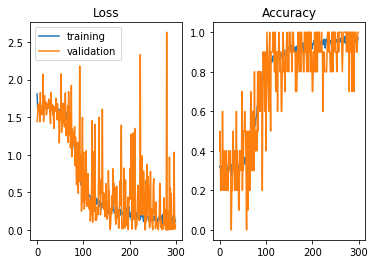

In [44]:
plt.figure(1)
plt.subplot(121)
plt.plot(range(len(train_loss)), train_loss, label='training')
plt.plot(range(len(test_loss)), test_loss, label='validation')
plt.title('Loss')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(range(len(train_acc)), train_acc, label='training')
plt.plot(range(len(test_acc)), test_acc, label='validation')
plt.title('Accuracy')